In [1]:
import numpy as np
import MDAnalysis as mda
import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

In [2]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

In [3]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc
U = mda.Universe('data/Ala10.pdb')
traj = Trajectory(U, selection='protein', match_FoXS=False)
frame = traj.Frames[0]
# print(frame.mol.vdW)
env = Environment(c2=2)
mea = Measurement(q = np.linspace(0.00, 0.5, num=101))
frame.SASA_calc(env, force_recalc=True)

FF_q = FF_calc(frame, env, mea)
# XS = frame_XS_calc(frame, env, mea)
# an i by j matrix of distances between all atoms
# d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

# XS = np.zeros(np.shape(mea.q))
# for i in np.arange(frame.mol.n_atoms):
#     for j in np.arange(i+1, frame.mol.n_atoms):
#         qd = mea.q * d_ij[i,j]
#         XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
#     XS += FF_q[i] ** 2

The protein has 104 atoms


In [4]:
XS

array([8176961.42066028, 8162174.47260291, 8117965.06670414,
       8044785.08425881, 7943379.60070685, 7814774.97467962,
       7660262.52626686, 7481378.14722889, 7279878.26869971,
       7057712.6839752 , 6816994.78355698, 6559969.80535128,
       6288981.73382368, 6006439.49741949, 5714783.11352526,
       5416450.41502436, 5113844.96271753, 4809305.70470948,
       4505078.88869986, 4203292.66769534, 3905934.76600799,
       3614833.49259113, 3331642.30513342, 3057828.04311763,
       2794662.86355269, 2543219.83146757, 2304372.04053038,
       2078795.06911022, 1866972.51530334, 1669204.30210832,
       1485617.40201875, 1316178.59935946, 1160708.88899811,
       1018899.1015105 ,  890326.34707422,  774470.88261103,
        670733.02804755,  578449.78685409,  496910.86192663,
        425373.7989474 ,  363078.03409025,  309257.66979902,
        263152.84987281,  224019.65182919,  191138.45919593,
        163820.81786813,  141414.81800335,  123309.0753632 ,
        108935.4129989 ,

In [41]:

importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

def frame_XS_calc_exp(frame, env, mea, num_q_pt=200, center_xyz=True, ignoreSASA=False, timing=False):
    q_sphere = raster_unit_sphere(num_q_pt)
    
    # Center xyz
    if center_xyz:
        xyz = frame.xyz - np.mean(frame.xyz, axis=0)
    else:
        xyz = frame.xyz

    t0 = time.time()
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)
    t1 = time.time()
    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    t2 = time.time()
    # Calculate scattering signal XS - currently this is quite slow. There has to be a way to make it faster
    XS = np.zeros(np.shape(mea.q))

    for idx, q in enumerate(mea.q):
        A = np.sum(FF_q[:,idx] * np.exp(-(1j) * q * np.dot(q_sphere, xyz.T)), axis=1)
        XS[idx] = np.mean(np.abs(A)**2)
    t3 = time.time()
    if timing:
        time_ms(t1, t0, 'SASA')
        time_ms(t2, t1, '  FF')
        time_ms(t3, t2, 'Xray')
    return XS

In [21]:
def frame_XS_calc_fast(frame, env, mea, ignoreSASA=False, timing=False): # Calculate the X-ray scattering of a frame
    t0 = time.time()
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)
    t1 = time.time()
    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    t2 = time.time()
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))
    d_ij += np.eye(len(d_ij)) * 1e-15
    t3 = time.time()

    # Calculate scattering signal XS - currently this is quite slow. There has to be a way to make it faster
    XS = np.zeros(np.shape(mea.q))
#     print((FF_q[:,None,:] * FF_q[:,:,None]).shape)

# This huge one-liner is slow
#     XS = np.sum((FF_q[:,None,:] * FF_q[:,:,None]) * np.sinc(mea.q[:, None, None] * d_ij[None,:,:] / np.pi), axis=(-1, -2))

# This q by q version is pretty good
    for idx, q in enumerate(mea.q):
        if q == 0.0:
            XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]))
#         XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]) * np.sinc(d_ij * q / np.pi))
        else:
            XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]) * np.sin(d_ij * q) / (d_ij * q))
    t4 = time.time()
    
# This element by element version is really slow
#     for i in np.arange(frame.mol.n_atoms):
#         for j in np.arange(i+1, frame.mol.n_atoms):
#             qd = mea.q * d_ij[i,j]
#             XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
#         XS += FF_q[i] ** 2

    if timing:
        time_ms(t1, t0, 'SASA')
        time_ms(t2, t1, '  FF')
        time_ms(t3, t2, 'dist')
        time_ms(t4, t3, 'Xray')
    return XS

In [236]:
# Useless!!
from numba import njit, prange

@njit(parallel=True)
def mul(a, b):
    alen = len(a)
    out = np.zeros((len(a), len(b)))
    for i in prange(alen):
        out[i] = a[i] * b
    return out

@njit(parallel=True)
def XSfunc(f, d, q):
    flen = len(f)
    dlen = len(d)
    out = np.zeros((len(f), len(d)))
    for i in prange(flen):
        for j in range(dlen):
            out[i] = f[i] * np.sinc(d[i] * q / np.pi)
    return np.sum(out)

def frame_XS_calc_fast_chunk(frame, env, mea, ignoreSASA=False, timing=False): # Calculate the X-ray scattering of a frame
    t0 = time.time()
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)
    t1 = time.time()
    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    t2 = time.time()
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))
    d_ij += np.eye(len(d_ij)) * 1e-15
    t3 = time.time()

# Calculate scattering signal XS
    XS = np.zeros(np.shape(mea.q))

# This q by q version is pretty good
    for idx, q in enumerate(mea.q):
#         print(np.repeat(FF_q[:,idx][:, None], len(FF_q), axis=1).shape)
#         FF_jk = FF_q[:,idx][:, None] * FF_q[:,idx][None, :]
        FF_jk = mul(FF_q[:,idx], FF_q[:,idx])
        if q == 0.0:
            XS[idx] += np.sum(FF_jk)
        else:
#             XS[idx] += np.sum(FF_jk * np.sin(d_ij * q) / (d_ij * q))
            XS[idx] += XSfunc(FF_jk, d_ij, q)
    t4 = time.time()
    
    if timing:
        time_ms(t1, t0, 'SASA')
        time_ms(t2, t1, '  FF')
        time_ms(t3, t2, 'dist')
        time_ms(t4, t3, 'Xray')
    return XS

In [263]:
U = mda.Universe('data/6lyz.pdb')
traj = Trajectory(U, selection='protein', match_FoXS=False)
frame = traj.Frames[0]
env = Environment(c2=2)
mea = Measurement(q = np.linspace(0.00, 0.5, num=101))
frame.SASA_calc(env, force_recalc=True)

The protein has 1001 atoms


In [264]:
# t0 = time.time()
# XS3 = frame_XS_calc_fast_chunk(frame, env, mea, timing=True)
# t1 = time.time()
# time_ms(t1, t0)
# print(XS3[0])

In [265]:
import time
def time_ms(t1, t0, message=None):
    if message is not None and len(message) > 0:
        print(f'{message}: {(t1-t0)*1000:.2f} ms')
    else:
        print(f'{(t1-t0)*1000:.2f} ms')

In [266]:
t0 = time.time()
XS = frame_XS_calc_fast(frame, env, mea, timing=True)
t1 = time.time()
time_ms(t1, t0, 'overall')

SASA: 0.01 ms
  FF: 60.44 ms
dist: 29.13 ms
Xray: 819.38 ms
overall: 909.61 ms


In [267]:
t0 = time.time()
XS2 = frame_XS_calc_exp(frame, env, mea, num_q_pt=500, timing=True) 
t1 = time.time()
time_ms(t1, t0, '')

SASA: 0.00 ms
  FF: 34.53 ms
Xray: 1111.99 ms
1150.96 ms


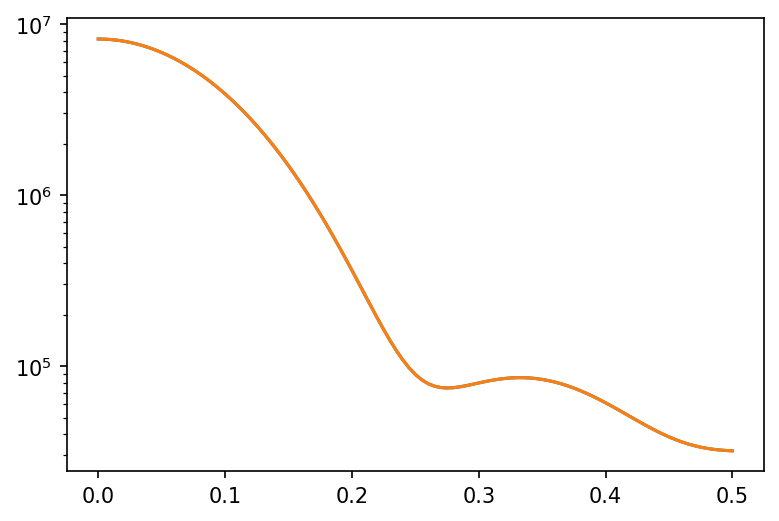

In [268]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.plot(mea.q, XS)
plt.plot(mea.q, XS2)
# plt.plot(mea.q, XS3)
plt.yscale('log')

In [42]:
XS2_diag = []
XS2_error2 = []
q_range = list(range(10, 210, 10))
for i in q_range:
    print(i, end=' ')
    XS2_this = frame_XS_calc_exp(frame, env, mea, num_q_pt=i, center_xyz=False, timing=False)
#     print(XS2_this)
    XS2_diag.append(XS2_this)
    XS2_error2.append(np.sqrt(np.sum(((XS2_this - XS)/XS)**2)))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 

In [38]:
XS2_error

[1.8985492724898854,
 0.46680335744719714,
 0.5132896720454758,
 0.24183048527726095,
 0.07809341108995481,
 0.057180511264179786,
 0.05322394266709959,
 0.0028062587614394677,
 0.03311272162705705,
 0.01445799046619544,
 0.01098072945552965,
 0.0073499863415502015,
 0.008723811299493784,
 0.016940426820591756,
 0.0054887073605464475,
 0.006779320333843965,
 0.010694190181505723,
 0.002430357677215782,
 0.005112444238731296,
 0.008604469143464936,
 0.0025648240609209135,
 0.0035320252223749495,
 0.007157176161927432,
 0.0022204170391315605,
 0.00048746729027388474,
 0.00342241626139256,
 0.004768412382497394,
 0.0013818970428405022,
 0.001594813893006823,
 0.0034206196574240117,
 0.0031779302423473165,
 0.0008694948205572801,
 0.0013232529055927321,
 0.0027593984723449675,
 0.0029047367858366447,
 0.0008400192298292465,
 0.0005679586329067264,
 0.0019246587180585754,
 0.0029980234059261137,
 0.000982251180938954,
 0.00013292669796242837,
 0.0012111443799802852,
 0.002224541787280805,
 

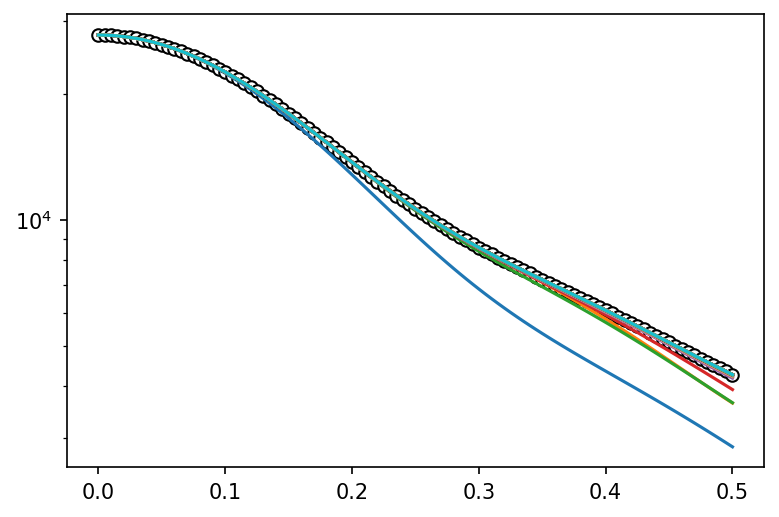

In [39]:
plt.figure(dpi=150)
plt.plot(mea.q, XS, '-ok', markerfacecolor='w')
for idx, i in enumerate(q_range):
    plt.plot(mea.q, XS2_diag[idx])
plt.yscale('log')
plt.show()

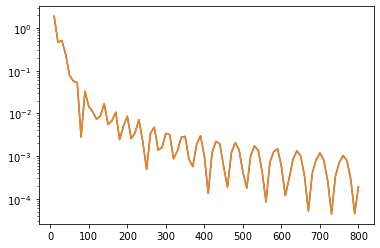

In [43]:
plt.figure()
plt.plot(q_range, XS2_error)
plt.plot(q_range, XS2_error2)
plt.yscale('log')
plt.show()